In [1]:
from langgraph.graph import StateGraph, START, END, add_messages
from typing import TypedDict, Annotated, List
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from langchain_community.tools import TavilySearchResults
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage
from IPython.display import Image, display
from uuid import uuid4

In [2]:
memory=MemorySaver()

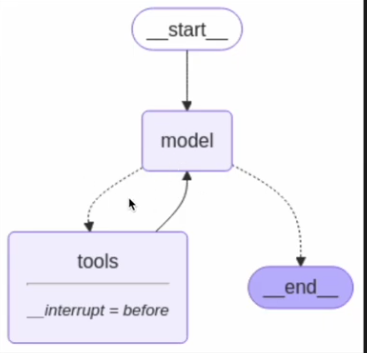

In [3]:
search_tool=TavilySearchResults(max_results=2)

In [4]:
tools=[search_tool]

In [5]:
llmLlama=ChatGroq(model="llama-3.1-8b-instant")

In [6]:
llm_with_tools=llmLlama.bind_tools(tools=tools)

In [7]:
class BasicState(TypedDict):
    messages:Annotated[List, add_messages]

In [8]:
def model(state:BasicState):
    state['message']=[llm_with_tools.invoke(input=state["messages"])]
    return state

In [9]:
def tools_router(state: BasicState):
    last_message=state['messages'][-1]
    if (hasattr(last_message,"tool_calls")) and len(last_message.tool_calls)>0:
        return "tools"
    else:
        return "end"

In [10]:
graph=StateGraph(BasicState)

In [11]:
graph.add_node(node="model",action=model)

In [12]:
graph.add_node(node="tools",action=ToolNode(tools=tools))

In [13]:
graph.add_conditional_edges(
    source="model",
    path=tools_router,
    path_map={
            "tools":"tools",
            "end":END
            })

In [14]:
graph.add_edge(start_key="tools",end_key="model")

In [15]:
graph.set_entry_point(key="model")

In [16]:
app=graph.compile(checkpointer=memory, interrupt_before=["tools"])

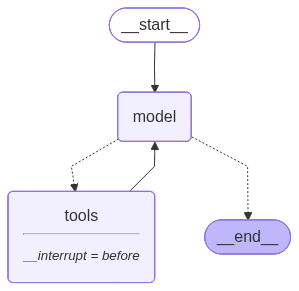

In [17]:
display(Image(data=app.get_graph().draw_mermaid_png()))

In [18]:
app.get_graph().print_ascii()

        +-----------+         
        | __start__ |         
        +-----------+         
              *               
              *               
              *               
          +-------+           
          | model |           
          +-------+           
         .         .          
       ..           ..        
      .               .       
+-------+         +---------+ 
| tools |         | __end__ | 
+-------+         +---------+ 


In [19]:
config={
    "configurable":{
        "thread_id": uuid4()
    }
}
config

{'configurable': {'thread_id': UUID('f4c242b0-d60f-410f-a9ef-58f5fc55caa0')}}

In [20]:
events=app.stream(input={
    "messages": [HumanMessage(content="What is the current weather in Bangalore?")]
}, config=config, stream_mode="values")

In [21]:
for event in events:
    print(event['messages'])
    print(event['messages'][-1],"\n")
    event['messages'][-1].pretty_print()
    print("--"*50)


[HumanMessage(content='What is the current weather in Bangalore?', additional_kwargs={}, response_metadata={}, id='d891a04d-9691-4e8f-a642-02704c509f0b')]
content='What is the current weather in Bangalore?' additional_kwargs={} response_metadata={} id='d891a04d-9691-4e8f-a642-02704c509f0b' 

================================ Human Message =================================

What is the current weather in Bangalore?
----------------------------------------------------------------------------------------------------
[HumanMessage(content='What is the current weather in Bangalore?', additional_kwargs={}, response_metadata={}, id='d891a04d-9691-4e8f-a642-02704c509f0b')]
content='What is the current weather in Bangalore?' additional_kwargs={} response_metadata={} id='d891a04d-9691-4e8f-a642-02704c509f0b' 

================================ Human Message =================================

What is the current weather in Bangalore?
-----------------------------------------------------------------

In [22]:
snapshot=app.get_state(config=config)

In [23]:
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='What is the current weather in Bangalore?', additional_kwargs={}, response_metadata={}, id='d891a04d-9691-4e8f-a642-02704c509f0b')]}, next=(), config={'configurable': {'thread_id': 'f4c242b0-d60f-410f-a9ef-58f5fc55caa0', 'checkpoint_ns': '', 'checkpoint_id': '1f0ea635-943d-6ef5-8001-c2f009d3f193'}}, metadata={'source': 'loop', 'writes': {'model': {'messages': [HumanMessage(content='What is the current weather in Bangalore?', additional_kwargs={}, response_metadata={}, id='d891a04d-9691-4e8f-a642-02704c509f0b')]}}, 'step': 1, 'parents': {}, 'thread_id': 'f4c242b0-d60f-410f-a9ef-58f5fc55caa0'}, created_at='2026-01-05T18:21:26.876747+00:00', parent_config={'configurable': {'thread_id': 'f4c242b0-d60f-410f-a9ef-58f5fc55caa0', 'checkpoint_ns': '', 'checkpoint_id': '1f0ea635-90ee-6237-8000-8a41f13dd1d9'}}, tasks=())

In [24]:
snapshot.next

()

In [25]:
events=app.stream(input=None, config=config, stream_mode="values")

In [26]:
for event in events:
    print(event['messages'])
    print(event['messages'][-1],"\n")
    event['messages'][-1].pretty_print()
    print("--"*50)

[HumanMessage(content='What is the current weather in Bangalore?', additional_kwargs={}, response_metadata={}, id='d891a04d-9691-4e8f-a642-02704c509f0b')]
content='What is the current weather in Bangalore?' additional_kwargs={} response_metadata={} id='d891a04d-9691-4e8f-a642-02704c509f0b' 

================================ Human Message =================================

What is the current weather in Bangalore?
----------------------------------------------------------------------------------------------------
